## Visualizing Heatmaps of Class Activation

Heatmaps of class activations are very helpful in identifying which parts of an image led the CNN to the final classification. It becomes very important when analyzing misclassified data.

We are going to use an implementation of Class Activation Map (CAM) that was used in the paper, [**"Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization"**](https://arxiv.org/abs/1610.02391)


### Loading VGG16 with pretrained weights

In [6]:
from keras.applications import VGG16
from keras import backend as K
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input, decode_predictions
import tensorflow as tf
tf.compat.v1.disable_eager_execution()

In [9]:
model = VGG16(weights='imagenet')

### Loading our test image of a Tiger

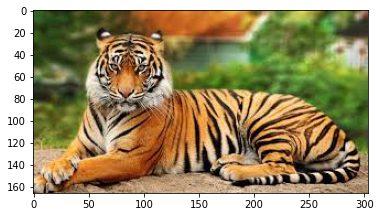

In [17]:
img_path = 'tiger.jpg'

img1 = image.load_img(img_path)
plt.imshow(img1);

img = image.load_img(img_path, target_size=(224, 224))

x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

### Getting our VGG16 ImageNet Prediction for the input image

In [18]:
preds = model.predict(x)
print('Predicted:', decode_predictions(preds, top=3)[0])

Predicted: [('n02129604', 'tiger', 0.74897873), ('n02123159', 'tiger_cat', 0.25051638), ('n02128925', 'jaguar', 0.00031675742)]


### Getting the class index

In [19]:
np.argmax(preds[0])

292

### Output the feature map of the block5_conv3 layer, the last convolutional layer in VGG16

In [20]:
tiger_output = model.output[:, 292]
last_conv_layer = model.get_layer('block5_conv3')

# Gradients of the Tiger class wrt to the block5_conv3 filer
grads = K.gradients(tiger_output, last_conv_layer.output)[0]

# Each entry is the mean intensity of the gradient over a specific feature-map channel 
pooled_grads = K.mean(grads, axis=(0, 1, 2))

# Accesses the values we just defined given our sample image
iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])

# Values of pooled_grads_value, conv_layer_output_value given our input image
pooled_grads_value, conv_layer_output_value = iterate([x])

# We multiply each channel in the feature-map array by the 'importance' 
# of this channel regarding the input image 
for i in range(512):
    #channel-wise mean of the resulting feature map is the Heatmap of the CAM
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

heatmap = np.mean(conv_layer_output_value, axis=-1)

### Ploting out Heat-Map

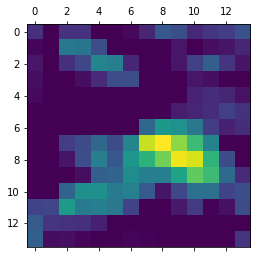

In [21]:
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)

### Using OpenCV to Overlay the heatmap onto our input image

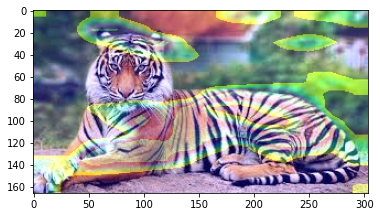

In [23]:
import cv2

img = cv2.imread(img_path)
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = heatmap * 0.4 + img

save_img_path = 'tiger1.jpeg'

cv2.imwrite(save_img_path, superimposed_img)

img1 = image.load_img(save_img_path)
plt.imshow(img1);